# Euclid Q1: cloud access

## Learning Goals
By the end of this tutorial, you will:
- Learn where Euclid Q1 data are stored in the cloud.
- Retrieve an image cutout from the cloud.
- Retrieve a spectrum from the cloud.

## 1. Introduction

Euclid launched in July 2023 as a European Space Agency (ESA) mission with involvement by NASA.
The primary science goals of Euclid are to better understand the composition and evolution of the dark Universe.
The Euclid mission is providing space-based imaging and spectroscopy as well as supporting ground-based imaging to achieve these primary goals.
These data will be archived by multiple global repositories, including IRSA, where they will support transformational work in many areas of astrophysics.

Euclid Quick Release 1 (Q1) consists of consists of ~30 TB of imaging, spectroscopy, and catalogs covering four non-contiguous fields:
Euclid Deep Field North (22.9 sq deg), Euclid Deep Field Fornax (12.1 sq deg), Euclid Deep Field South (28.1 sq deg), and LDN1641.

IRSA maintains copies of the Euclid Q1 data products both on premises at IPAC and on the cloud via Amazon Web Services (AWS).
This notebook provides an introduction to accessing Euclid Q1 data from the cloud.
If you have questions, please contact the [IRSA helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html).

## 2. Imports
- `s3fs` for browsing S3 buckets
- `astropy` for handling coordinates, units, FITS I/O, tables, images, etc.
- `astroquery>=0.4.10` for querying Euclid data products from IRSA
- `matplotlib` for visualization
- `json` for decoding JSON strings

```{important}
We rely on ``astroquery`` features that have been recently added, so please make sure you have version v0.4.10 or newer installed.
```

In [1]:
# Uncomment the next line to install dependencies if needed.
# !pip install s3fs astropy 'astroquery>=0.4.10' matplotlib

In [2]:
import s3fs
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.table import Table
from astroquery.ipac.irsa import Irsa
from matplotlib import pyplot as plt
import json

## 3. Browse Euclid Q1 cloud-hosted data

In [3]:
BUCKET_NAME = 'nasa-irsa-euclid-q1'

[s3fs](https://s3fs.readthedocs.io/en/latest/) provides a filesystem-like python interface for AWS S3 buckets. First we create a s3 client:

In [4]:
s3 = s3fs.S3FileSystem(anon=True)

Then we list the `q1` directory that contains Euclid Q1 data products:

In [5]:
s3.ls(f'{BUCKET_NAME}/q1')

['nasa-irsa-euclid-q1/q1/MER',
 'nasa-irsa-euclid-q1/q1/MER_SEG',
 'nasa-irsa-euclid-q1/q1/NIR',
 'nasa-irsa-euclid-q1/q1/RAW',
 'nasa-irsa-euclid-q1/q1/SIR',
 'nasa-irsa-euclid-q1/q1/VIS',
 'nasa-irsa-euclid-q1/q1/VMPZ',
 'nasa-irsa-euclid-q1/q1/catalogs']

Let's navigate to MER images (available as FITS files):

In [6]:
s3.ls(f'{BUCKET_NAME}/q1/MER')[:10] # ls only top 10 to limit the long output

['nasa-irsa-euclid-q1/q1/MER/102018211',
 'nasa-irsa-euclid-q1/q1/MER/102018212',
 'nasa-irsa-euclid-q1/q1/MER/102018213',
 'nasa-irsa-euclid-q1/q1/MER/102018664',
 'nasa-irsa-euclid-q1/q1/MER/102018665',
 'nasa-irsa-euclid-q1/q1/MER/102018666',
 'nasa-irsa-euclid-q1/q1/MER/102018667',
 'nasa-irsa-euclid-q1/q1/MER/102018668',
 'nasa-irsa-euclid-q1/q1/MER/102018669',
 'nasa-irsa-euclid-q1/q1/MER/102018670']

In [7]:
s3.ls(f'{BUCKET_NAME}/q1/MER/102018211') # pick any tile ID from above

['nasa-irsa-euclid-q1/q1/MER/102018211/DECAM',
 'nasa-irsa-euclid-q1/q1/MER/102018211/NISP',
 'nasa-irsa-euclid-q1/q1/MER/102018211/VIS']

In [8]:
s3.ls(f'{BUCKET_NAME}/q1/MER/102018211/VIS') # pick any instrument from above

['nasa-irsa-euclid-q1/q1/MER/102018211/VIS/EUC_MER_BGMOD-VIS_TILE102018211-4CD9D_20241018T142710.276652Z_00.00.fits',
 'nasa-irsa-euclid-q1/q1/MER/102018211/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102018211-ACBD03_20241018T142710.276838Z_00.00.fits',
 'nasa-irsa-euclid-q1/q1/MER/102018211/VIS/EUC_MER_CATALOG-PSF-VIS_TILE102018211-55C665_20241018T204235.689380Z_00.00.fits',
 'nasa-irsa-euclid-q1/q1/MER/102018211/VIS/EUC_MER_GRID-PSF-VIS_TILE102018211-9A5C08_20241018T142525.109781Z_00.00.fits',
 'nasa-irsa-euclid-q1/q1/MER/102018211/VIS/EUC_MER_MOSAIC-VIS-FLAG_TILE102018211-40A124_20241018T142525.109767Z_00.00.fits',
 'nasa-irsa-euclid-q1/q1/MER/102018211/VIS/EUC_MER_MOSAIC-VIS-RMS_TILE102018211-B3070B_20241018T142525.109753Z_00.00.fits']

As per "Browsable Directories" section in [user guide](https://irsa.ipac.caltech.edu/data/Euclid/docs/euclid_archive_at_irsa_user_guide.pdf), we need `MER/{tile_id}/{instrument}/EUC_MER_BGSUB-MOSAIC*.fits` for displaying background-subtracted mosiac images. But these images are stored under TILE IDs so first we need to find TILE ID for a coordinate search we are interested in. We will use astroquery (in next section) to retrieve FITS file paths for our coordinates by doing spatial search.

## 4. Do a spatial search for MER mosaics

Pick a target and search radius:

In [9]:
target_name = 'TYC 4429-1677-1'
coord = SkyCoord.from_name(target_name)
search_radius = 10 * u.arcsec

% List all Simple Image Access (SIA) collections for IRSA with names containing "euclid":
%
% ```{code-cell} ipython3
% collections = Irsa.list_collections(servicetype='SIA', filter='euclid')
% collections
% ```

As per "Data Products Overview" in [user guide](https://irsa.ipac.caltech.edu/data/Euclid/docs/euclid_archive_at_irsa_user_guide.pdf) and above table, we identify that MER Mosiacs are available as the following collection:

In [10]:
img_collection = 'euclid_DpdMerBksMosaic'

Now query this collection for our target's coordinates and search radius:

In [11]:
img_tbl = Irsa.query_sia(pos=(coord, search_radius), collection=img_collection)
img_tbl

s_ra,s_dec,facility_name,instrument_name,dataproduct_subtype,calib_level,dataproduct_type,energy_bandpassname,energy_emband,obs_id,s_resolution,em_min,em_max,em_res_power,proposal_title,access_url,access_format,access_estsize,t_exptime,s_region,obs_collection,obs_intent,algorithm_name,facility_keywords,instrument_keywords,environment_photometric,proposal_id,proposal_pi,proposal_project,target_name,target_type,target_standard,target_moving,target_keywords,obs_release_date,s_xel1,s_xel2,s_pixel_scale,position_timedependent,t_min,t_max,t_resolution,t_xel,obs_publisher_did,s_fov,em_xel,pol_states,pol_xel,cloud_access,o_ucd,upload_row_id
deg,deg,,,,,,,,,arcsec,m,m,,,,,kbyte,s,deg,,,,,,,,,,,,,,,,,,arcsec,,d,d,s,,,deg,,,,,,
float64,float64,object,object,object,int16,object,object,object,object,float64,float64,float64,float64,object,object,object,int64,float64,object,object,object,object,object,object,bool,object,object,object,object,object,bool,bool,object,object,int64,int64,float64,bool,float64,float64,float64,int64,object,float64,int64,object,int64,object,object,int64
273.07162262404495,68.00001388888474,Euclid,NISP,auxiliary,3,image,Y,Infrared,102160339_NISP,0.0878,9.2e-07,1.146e-06,4.6,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102160339/NISP/EUC_MER_CATALOG-PSF-NIR-Y_TILE102160339-E72766_20241025T072629.031850Z_00.00.fits,image/fits,549787,--,POLYGON ICRS 273.7917384920759 68.26512213776137 272.3515059037093 68.2651218134747 272.3679070260387 67.73183349848344 273.7753390775804 67.73183381419538 273.7917384920759 68.26512213776137,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,--,,,,,field,--,False,,2025-05-01 00:00:00,19200,19200,0.100000000000008,False,--,--,--,--,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102160339_NISP/Y,0.533333333333376,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102160339/NISP/EUC_MER_CATALOG-PSF-NIR-Y_TILE102160339-E72766_20241025T072629.031850Z_00.00.fits"", ""region"": ""us-east-1""}}",,1
273.07162262404495,68.00001388888474,Euclid,NISP,science,3,image,Y,Infrared,102160339_NISP,0.0878,9.2e-07,1.146e-06,4.6,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102160339/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102160339-3A9BC7_20241024T231706.521789Z_00.00.fits,image/fits,1474566,--,POLYGON ICRS 273.7917384920759 68.26512213776137 272.3515059037093 68.2651218134747 272.3679070260387 67.73183349848344 273.7753390775804 67.73183381419538 273.7917384920759 68.26512213776137,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,--,,,,,field,--,False,,2025-05-01 00:00:00,19200,19200,0.100000000000008,False,--,--,--,--,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102160339_NISP/Y,0.533333333333376,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102160339/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102160339-3A9BC7_20241024T231706.521789Z_00.00.fits"", ""region"": ""us-east-1""}}",,1
273.07162262404495,68.00001388888474,Euclid,NISP,noise,3,image,Y,Infrared,102160339_NISP,0.0878,9.2e-07,1.146e-06,4.6,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102160339/NISP/EUC_MER_MOSAIC-NIR-Y-RMS_TILE102160339-975287_20241024T223523.501123Z_00.00.fits,image/fits,1474566,--,POLYGON ICRS 273.7917384920759 68.26512213776137 272.3515059037093 68.2651218134747 272.3679070260387 67.73183349848344 273.7753390775804 67.73183381419538 273.7917384920759 68.26512213776137,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,--,,,,,field,--,False,,2025-05-01 00:00:00,19200,19200,0.100000000000008,False,--,--,--,--,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102160339_NISP/Y,0.533333333333376,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102160339/NISP/EUC_MER_MOSAIC-NIR-Y-RMS_TILE102160339-975287_20241024T223523.501123Z_00.00.fits"", ""region"": ""us-east-1""}}",,1
273.07162262404495,68.00001388888474,Euclid,NISP,auxiliary,3,image,Y,Infrared,102160339_NISP,0.0878,9.2e-07,1.146e-06,4.6,Euclid on-the-fly,https://irsa.ipac.caltech.edu/

Let's narrow it down to the images with science dataproduct subtype and Euclid facility:

In [12]:
euclid_sci_img_tbl = img_tbl[[row['facility_name']=='Euclid'
                              and row['dataproduct_subtype']=='science'
                              for row in img_tbl]]
euclid_sci_img_tbl

s_ra,s_dec,facility_name,instrument_name,dataproduct_subtype,calib_level,dataproduct_type,energy_bandpassname,energy_emband,obs_id,s_resolution,em_min,em_max,em_res_power,proposal_title,access_url,access_format,access_estsize,t_exptime,s_region,obs_collection,obs_intent,algorithm_name,facility_keywords,instrument_keywords,environment_photometric,proposal_id,proposal_pi,proposal_project,target_name,target_type,target_standard,target_moving,target_keywords,obs_release_date,s_xel1,s_xel2,s_pixel_scale,position_timedependent,t_min,t_max,t_resolution,t_xel,obs_publisher_did,s_fov,em_xel,pol_states,pol_xel,cloud_access,o_ucd,upload_row_id
deg,deg,,,,,,,,,arcsec,m,m,,,,,kbyte,s,deg,,,,,,,,,,,,,,,,,,arcsec,,d,d,s,,,deg,,,,,,
float64,float64,object,object,object,int16,object,object,object,object,float64,float64,float64,float64,object,object,object,int64,float64,object,object,object,object,object,object,bool,object,object,object,object,object,bool,bool,object,object,int64,int64,float64,bool,float64,float64,float64,int64,object,float64,int64,object,int64,object,object,int64
273.07162262404495,68.00001388888474,Euclid,NISP,science,3,image,Y,Infrared,102160339_NISP,0.0878,9.2e-07,1.146e-06,4.6,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102160339/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102160339-3A9BC7_20241024T231706.521789Z_00.00.fits,image/fits,1474566,--,POLYGON ICRS 273.7917384920759 68.26512213776137 272.3515059037093 68.2651218134747 272.3679070260387 67.73183349848344 273.7753390775804 67.73183381419538 273.7917384920759 68.26512213776137,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,--,,,,,field,--,False,,2025-05-01 00:00:00,19200,19200,0.100000000000008,False,--,--,--,--,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102160339_NISP/Y,0.533333333333376,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102160339/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102160339-3A9BC7_20241024T231706.521789Z_00.00.fits"", ""region"": ""us-east-1""}}",,1
273.07162262404495,68.00001388888474,Euclid,NISP,science,3,image,J,Infrared,102160339_NISP,0.094,1.146e-06,1.372e-06,5.6,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102160339/NISP/EUC_MER_BGSUB-MOSAIC-NIR-J_TILE102160339-B6EC5E_20241024T230609.320185Z_00.00.fits,image/fits,1474566,--,POLYGON ICRS 273.7917384920759 68.26512213776137 272.3515059037093 68.2651218134747 272.3679070260387 67.73183349848344 273.7753390775804 67.73183381419538 273.7917384920759 68.26512213776137,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,--,,,,,field,--,False,,2025-05-01 00:00:00,19200,19200,0.100000000000008,False,--,--,--,--,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102160339_NISP/J,0.533333333333376,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102160339/NISP/EUC_MER_BGSUB-MOSAIC-NIR-J_TILE102160339-B6EC5E_20241024T230609.320185Z_00.00.fits"", ""region"": ""us-east-1""}}",,1
273.07162262404495,68.00001388888474,Euclid,NISP,science,3,image,H,Infrared,102160339_NISP,0.1026,1.372e-06,2e-06,2.7,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102160339/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102160339-539320_20241024T230405.104628Z_00.00.fits,image/fits,1474566,--,POLYGON ICRS 273.7917384920759 68.26512213776137 272.3515059037093 68.2651218134747 272.3679070260387 67.73183349848344 273.7753390775804 67.73183381419538 273.7917384920759 68.26512213776137,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,--,,,,,field,--,False,,2025-05-01 00:00:00,19200,19200,0.100000000000008,False,--,--,--,--,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102160339_NISP/H,0.533333333333376,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102160339/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102160339-539320_20241024T230405.104628Z_00.00.fits"", ""region"": ""us-east-1""}}",,1
273.07162262404495,68.00001388888474,Euclid,VIS,science,3,image,VIS,Optical,102160339_VIS,0.16,5.5e-07,9e-07,2.1,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe

We can see there's a `cloud_access` column that gives us the location info of the image files we are interested in. So let's extract the S3 bucket file path from it:

In [13]:
def get_s3_fpath(cloud_access):
    cloud_info = json.loads(cloud_access) # converts str to dict
    bucket_name = cloud_info['aws']['bucket_name']
    key = cloud_info['aws']['key']

    return f'{bucket_name}/{key}'

In [14]:
[get_s3_fpath(row['cloud_access']) for row in euclid_sci_img_tbl]

['nasa-irsa-euclid-q1/q1/MER/102160339/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102160339-3A9BC7_20241024T231706.521789Z_00.00.fits',
 'nasa-irsa-euclid-q1/q1/MER/102160339/NISP/EUC_MER_BGSUB-MOSAIC-NIR-J_TILE102160339-B6EC5E_20241024T230609.320185Z_00.00.fits',
 'nasa-irsa-euclid-q1/q1/MER/102160339/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102160339-539320_20241024T230405.104628Z_00.00.fits',
 'nasa-irsa-euclid-q1/q1/MER/102160339/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102160339-ADF1FF_20241025T022657.824470Z_00.00.fits']

Let's also extract filter names to use when displaying the images:

In [15]:
def get_filter_name(instrument, bandpass):
    return f'{instrument}_{bandpass}' if instrument!=bandpass else instrument

In [16]:
[get_filter_name(row['instrument_name'], row['energy_bandpassname']) for row in euclid_sci_img_tbl]

['NISP_Y', 'NISP_J', 'NISP_H', 'VIS']

## 5. Efficiently retrieve mosaic cutouts
These image files are very big (~1.4GB), so we use astropy's lazy-loading capability of FITS for better performance. (See [Obtaining subsets from cloud-hosted FITS files](https://docs.astropy.org/en/stable/io/fits/usage/cloud.html#fits-io-cloud).)

In [17]:
cutout_size = 1 * u.arcmin

In [18]:
cutouts = []
filters = []

for row in euclid_sci_img_tbl:
    s3_fpath = get_s3_fpath(row['cloud_access'])
    filter_name = get_filter_name(row['instrument_name'], row['energy_bandpassname'])

    with fits.open(f's3://{s3_fpath}', fsspec_kwargs={"anon": True}) as hdul:
        print(f'Retrieving cutout for {filter_name} ...')
        cutout = Cutout2D(hdul[0].section,
                          position=coord,
                          size=cutout_size,
                          wcs=WCS(hdul[0].header))
        cutouts.append(cutout)
        filters.append(filter_name)

Retrieving cutout for NISP_Y ...
Retrieving cutout for NISP_J ...
Retrieving cutout for NISP_H ...
Retrieving cutout for VIS ...


Retrieving cutout for NISP_J ...


Retrieving cutout for NISP_H ...


Retrieving cutout for VIS ...


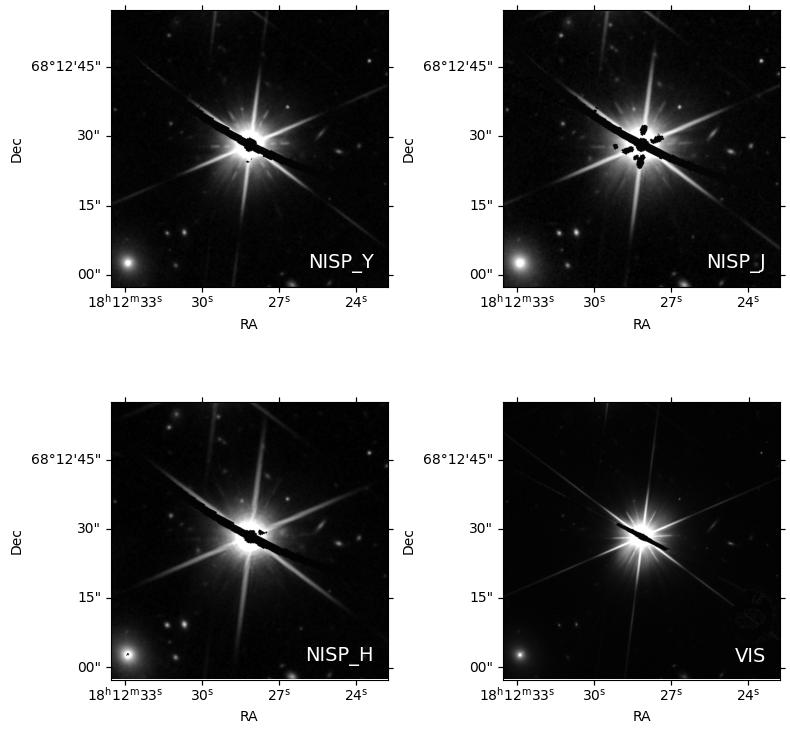

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(4 * 2, 4 * 2), subplot_kw={'projection': cutouts[0].wcs})

for idx, ax in enumerate(axes.flat):
    norm = ImageNormalize(cutouts[idx].data, interval=PercentileInterval(99), stretch=AsinhStretch())
    ax.imshow(cutouts[idx].data, cmap='gray', origin='lower', norm=norm)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.text(0.95, 0.05, filters[idx], color='white', fontsize=14, transform=ax.transAxes, va='bottom', ha='right')

plt.tight_layout()

## 6. Find the MER catalog for a given tile
Let's navigate to MER catalog in the Euclid Q1 bucket:

In [20]:
s3.ls(f'{BUCKET_NAME}/q1/catalogs')

['nasa-irsa-euclid-q1/q1/catalogs/MER_FINAL_CATALOG',
 'nasa-irsa-euclid-q1/q1/catalogs/NIR_CAL_CATALOG',
 'nasa-irsa-euclid-q1/q1/catalogs/PHZ_PF_OUTPUT_CATALOG',
 'nasa-irsa-euclid-q1/q1/catalogs/PHZ_PF_OUTPUT_FOR_L3',
 'nasa-irsa-euclid-q1/q1/catalogs/SPE_PF_OUTPUT_CATALOG',
 'nasa-irsa-euclid-q1/q1/catalogs/VIS_CAL_CATALOG']

In [21]:
s3.ls(f'{BUCKET_NAME}/q1/catalogs/MER_FINAL_CATALOG')[:10] # ls only top 10 to limit the long output

['nasa-irsa-euclid-q1/q1/catalogs/MER_FINAL_CATALOG/102018211',
 'nasa-irsa-euclid-q1/q1/catalogs/MER_FINAL_CATALOG/102018212',
 'nasa-irsa-euclid-q1/q1/catalogs/MER_FINAL_CATALOG/102018213',
 'nasa-irsa-euclid-q1/q1/catalogs/MER_FINAL_CATALOG/102018664',
 'nasa-irsa-euclid-q1/q1/catalogs/MER_FINAL_CATALOG/102018665',
 'nasa-irsa-euclid-q1/q1/catalogs/MER_FINAL_CATALOG/102018666',
 'nasa-irsa-euclid-q1/q1/catalogs/MER_FINAL_CATALOG/102018667',
 'nasa-irsa-euclid-q1/q1/catalogs/MER_FINAL_CATALOG/102018668',
 'nasa-irsa-euclid-q1/q1/catalogs/MER_FINAL_CATALOG/102018669',
 'nasa-irsa-euclid-q1/q1/catalogs/MER_FINAL_CATALOG/102018670']

In [22]:
mer_tile_id = 102160339 # from the image paths for the target we picked
s3.ls(f'{BUCKET_NAME}/q1/catalogs/MER_FINAL_CATALOG/{mer_tile_id}')

['nasa-irsa-euclid-q1/q1/catalogs/MER_FINAL_CATALOG/102160339/EUC_MER_FINAL-CAT_TILE102160339-52AA9D_20241026T145149.163369Z_00.00.fits',
 'nasa-irsa-euclid-q1/q1/catalogs/MER_FINAL_CATALOG/102160339/EUC_MER_FINAL-CUTOUTS-CAT_TILE102160339-7449E7_20241026T034412.641243Z_00.00.fits',
 'nasa-irsa-euclid-q1/q1/catalogs/MER_FINAL_CATALOG/102160339/EUC_MER_FINAL-MORPH-CAT_TILE102160339-52C86_20241026T145146.071857Z_00.00.fits']

As per "Browsable Directiories" section in [user guide](https://irsa.ipac.caltech.edu/data/Euclid/docs/euclid_archive_at_irsa_user_guide.pdf), we can use `catalogs/MER_FINAL_CATALOG/{tile_id}/EUC_MER_FINAL-CAT*.fits` for listing the objects catalogued. We can read the identified FITS file as table and do filtering on ra, dec columns to find object ID(s) only for the target we picked. But it will be an expensive operation so we will instead use astroquery (in next section) to do a spatial search in the MER catalog provided by IRSA.

```{note}
Once the catalogs are available as Parquet files in the cloud, we can efficiently do spatial filtering directly on the cloud-hosted file to identify object ID(s) for our target. But for the time being, we can use catalog VO services through astroquery to do the same.
```

## 7. Find the MER Object ID for our target
First, list the Euclid catalogs provided by IRSA:

In [23]:
catalogs = Irsa.list_catalogs(full=True, filter='euclid')
catalogs

table_index,schema_name,irsa_schema_name,table_name,description,table_type,utype,irsa_dbms,irsa_pos,irsa_sptlevel,irsa_missionid,irsa_groupid,irsa_access_flag,irsa_nrows,irsa_odbc_datasource,irsa_spatial_idx_name
int32,object,object,object,object,object,object,int32,object,int32,int32,int32,int32,int64,object,object
358,euclid,euclid,euclid_q1_mer_catalogue,Euclid Q1 MER Catalog,table,,21,y,20,-1,-1,30,29953430,euclid,NIX_EUCLID_Q1_MER_CATALOGUE_HTM20


From this table, we can extract the MER catalog name. We also see several other interesting catalogs, let's also extract spectral file association catalog for retrieving spectra later.

In [24]:
euclid_mer_catalog = 'euclid_q1_mer_catalogue'
euclid_spec_association_catalog = 'euclid.objectid_spectrafile_association_q1'

Now, we do a region search within a cone of 5 arcsec around our target to pinpoint its object ID in Euclid catalog:

In [25]:
search_radius = 5 * u.arcsec

mer_catalog_tbl = Irsa.query_region(coordinates=coord, spatial='Cone',
                                    catalog=euclid_mer_catalog, radius=search_radius)
mer_catalog_tbl

object_id,ra,dec,right_ascension_psf_fitting,declination_psf_fitting,segmentation_map_id,vis_det,flux_vis_1fwhm_aper,flux_vis_2fwhm_aper,flux_vis_3fwhm_aper,flux_vis_4fwhm_aper,flux_y_1fwhm_aper,flux_y_2fwhm_aper,flux_y_3fwhm_aper,flux_y_4fwhm_aper,flux_j_1fwhm_aper,flux_j_2fwhm_aper,flux_j_3fwhm_aper,flux_j_4fwhm_aper,flux_h_1fwhm_aper,flux_h_2fwhm_aper,flux_h_3fwhm_aper,flux_h_4fwhm_aper,flux_nir_stack_1fwhm_aper,flux_nir_stack_2fwhm_aper,flux_nir_stack_3fwhm_aper,flux_nir_stack_4fwhm_aper,flux_u_ext_decam_1fwhm_aper,flux_u_ext_decam_2fwhm_aper,flux_u_ext_decam_3fwhm_aper,flux_u_ext_decam_4fwhm_aper,flux_g_ext_decam_1fwhm_aper,flux_g_ext_decam_2fwhm_aper,flux_g_ext_decam_3fwhm_aper,flux_g_ext_decam_4fwhm_aper,flux_r_ext_decam_1fwhm_aper,flux_r_ext_decam_2fwhm_aper,flux_r_ext_decam_3fwhm_aper,flux_r_ext_decam_4fwhm_aper,flux_i_ext_decam_1fwhm_aper,flux_i_ext_decam_2fwhm_aper,flux_i_ext_decam_3fwhm_aper,flux_i_ext_decam_4fwhm_aper,flux_z_ext_decam_1fwhm_aper,flux_z_ext_decam_2fwhm_aper,flux_z_ext_decam_3fwhm_aper,flux_z_ext_decam_4fwhm_aper,flux_u_ext_lsst_1fwhm_aper,flux_u_ext_lsst_2fwhm_aper,flux_u_ext_lsst_3fwhm_aper,flux_u_ext_lsst_4fwhm_aper,flux_g_ext_lsst_1fwhm_aper,flux_g_ext_lsst_2fwhm_aper,flux_g_ext_lsst_3fwhm_aper,flux_g_ext_lsst_4fwhm_aper,flux_r_ext_lsst_1fwhm_aper,flux_r_ext_lsst_2fwhm_aper,flux_r_ext_lsst_3fwhm_aper,flux_r_ext_lsst_4fwhm_aper,flux_i_ext_lsst_1fwhm_aper,flux_i_ext_lsst_2fwhm_aper,flux_i_ext_lsst_3fwhm_aper,flux_i_ext_lsst_4fwhm_aper,flux_z_ext_lsst_1fwhm_aper,flux_z_ext_lsst_2fwhm_aper,flux_z_ext_lsst_3fwhm_aper,flux_z_ext_lsst_4fwhm_aper,flux_u_ext_megacam_1fwhm_aper,flux_u_ext_megacam_2fwhm_aper,flux_u_ext_megacam_3fwhm_aper,flux_u_ext_megacam_4fwhm_aper,flux_r_ext_megacam_1fwhm_aper,flux_r_ext_megacam_2fwhm_aper,flux_r_ext_megacam_3fwhm_aper,flux_r_ext_megacam_4fwhm_aper,flux_g_ext_jpcam_1fwhm_aper,flux_g_ext_jpcam_2fwhm_aper,flux_g_ext_jpcam_3fwhm_aper,flux_g_ext_jpcam_4fwhm_aper,flux_i_ext_panstarrs_1fwhm_aper,flux_i_ext_panstarrs_2fwhm_aper,flux_i_ext_panstarrs_3fwhm_aper,flux_i_ext_panstarrs_4fwhm_aper,flux_z_ext_panstarrs_1fwhm_aper,flux_z_ext_panstarrs_2fwhm_aper,flux_z_ext_panstarrs_3fwhm_aper,flux_z_ext_panstarrs_4fwhm_aper,flux_g_ext_hsc_1fwhm_aper,flux_g_ext_hsc_2fwhm_aper,flux_g_ext_hsc_3fwhm_aper,flux_g_ext_hsc_4fwhm_aper,flux_z_ext_hsc_1fwhm_aper,flux_z_ext_hsc_2fwhm_aper,flux_z_ext_hsc_3fwhm_aper,flux_z_ext_hsc_4fwhm_aper,fluxerr_vis_1fwhm_aper,fluxerr_vis_2fwhm_aper,fluxerr_vis_3fwhm_aper,fluxerr_vis_4fwhm_aper,fluxerr_y_1fwhm_aper,fluxerr_y_2fwhm_aper,fluxerr_y_3fwhm_aper,fluxerr_y_4fwhm_aper,fluxerr_j_1fwhm_aper,fluxerr_j_2fwhm_aper,fluxerr_j_3fwhm_aper,fluxerr_j_4fwhm_aper,fluxerr_h_1fwhm_aper,fluxerr_h_2fwhm_aper,fluxerr_h_3fwhm_aper,fluxerr_h_4fwhm_aper,fluxerr_nir_stack_1fwhm_aper,fluxerr_nir_stack_2fwhm_aper,fluxerr_nir_stack_3fwhm_aper,fluxerr_nir_stack_4fwhm_aper,fluxerr_u_ext_decam_1fwhm_aper,fluxerr_u_ext_decam_2fwhm_aper,fluxerr_u_ext_decam_3fwhm_aper,fluxerr_u_ext_decam_4fwhm_aper,fluxerr_g_ext_decam_1fwhm_aper,fluxerr_g_ext_decam_2fwhm_aper,fluxerr_g_ext_decam_3fwhm_aper,fluxerr_g_ext_decam_4fwhm_aper,fluxerr_r_ext_decam_1fwhm_aper,fluxerr_r_ext_decam_2fwhm_aper,fluxerr_r_ext_decam_3fwhm_aper,fluxerr_r_ext_decam_4fwhm_aper,fluxerr_i_ext_decam_1fwhm_aper,fluxerr_i_ext_decam_2fwhm_aper,fluxerr_i_ext_decam_3fwhm_aper,fluxerr_i_ext_decam_4fwhm_aper,fluxerr_z_ext_decam_1fwhm_aper,fluxerr_z_ext_decam_2fwhm_aper,fluxerr_z_ext_decam_3fwhm_aper,fluxerr_z_ext_decam_4fwhm_aper,fluxerr_u_ext_lsst_1fwhm_aper,fluxerr_u_ext_lsst_2fwhm_aper,fluxerr_u_ext_lsst_3fwhm_aper,fluxerr_u_ext_lsst_4fwhm_aper,fluxerr_g_ext_lsst_1fwhm_aper,fluxerr_g_ext_lsst_2fwhm_aper,fluxerr_g_ext_lsst_3fwhm_aper,fluxerr_g_ext_lsst_4fwhm_aper,fluxerr_r_ext_lsst_1fwhm_aper,fluxerr_r_ext_lsst_2fwhm_aper,fluxerr_r_ext_lsst_3fwhm_aper,fluxerr_r_ext_lsst_4fwhm_aper,fluxerr_i_ext_lsst_1fwhm_aper,fluxerr_i_ext_lsst_2fwhm_aper,fluxerr_i_ext_lsst_3fwhm_aper,fluxerr_i_ext_lsst_4fwhm_aper,fluxerr_z_ext_lsst_1fwhm_ap

In [26]:
object_id = int(mer_catalog_tbl['object_id'][0])
object_id

2731173428682078045

## 8. Find the spectrum of an object in the MER catalog
Using the object ID(s) we extracted above, we can narrow down the spectral file association catalog to identify spectra file path(s). So we do the following TAP search:

In [27]:
adql_query = f"SELECT * FROM {euclid_spec_association_catalog} \
    WHERE objectid = {object_id}"

spec_association_tbl = Irsa.query_tap(adql_query).to_table()
spec_association_tbl

objectid,tileid,path,hdu,obs_publisher_did,bandpass_name,label
int64,int64,object,int64,object,object,object
2731173428682078045,102160339,api/spectrumdm/convert/euclid/q1/SIR/102160339/EUC_SIR_W-COMBSPEC_102160339_2024-11-05T16:26:34.614296Z.fits?dataset_id=euclid_combspec&hdu=1644,1644,ivo://ipac.irsa/euclid_sir_combined?102160339/2731173428682078045,RGS,2731173428682078045 co-added spectrum


```{warning}
If you picked a target other than what this notebook uses, it's possible that there is no spectrum associated for your target's object ID. In that case, `spec_association_tbl` will contain 0 rows.
```

In above table, we can see that the `'path'` column gives us a url that can be used to call an IRSA service to get the spectrum of our object as SpectrumDM VOTable. We can map it to an S3 bucket key to retrieve a spectra file from the cloud. This is a very big FITS spectra file with multiple extensions where each extension contains spectrum of one object. The `'hdu'` column gives us the extension number for our object. So let's extract both of these.

In [28]:
spec_fpath_key = spec_association_tbl['path'][0].replace('api/spectrumdm/convert/euclid/', '').split('?')[0]
spec_fpath_key

'q1/SIR/102160339/EUC_SIR_W-COMBSPEC_102160339_2024-11-05T16:26:34.614296Z.fits'

In [29]:
object_hdu_idx = int(spec_association_tbl['hdu'][0])
object_hdu_idx

1644

Again, we use astropy's lazy-loading capability of FITS to only retrieve the spectrum table of our object from the S3 bucket.

In [30]:
with fits.open(f's3://{BUCKET_NAME}/{spec_fpath_key}', fsspec_kwargs={'anon': True}) as hdul:
    spec_hdu = hdul[object_hdu_idx]
    spec_tbl = Table.read(spec_hdu)
    spec_header = spec_hdu.header

In [31]:
spec_tbl

WAVELENGTH,SIGNAL,MASK,QUALITY,VAR,NDITH
Angstrom,erg / (Angstrom s cm2),Number,Number,erg2 / (Angstrom2 s2 cm4),Number
float32,float32,int32,float32,float32,int16
11900.0,0.0,1,0.0,0.0,0
11913.4,0.0,1,0.0,0.0,0
11926.8,0.0,1,0.0,0.0,0
11940.2,0.0,1,0.0,0.0,0
11953.6,533.2775,67,0.5919007,6.148728,1
11967.0,0.0,1,0.0,0.0,0
11980.4,450.44067,65,0.99010026,2.4839582,1
11993.8,253.39111,65,0.7950632,0.724125,1


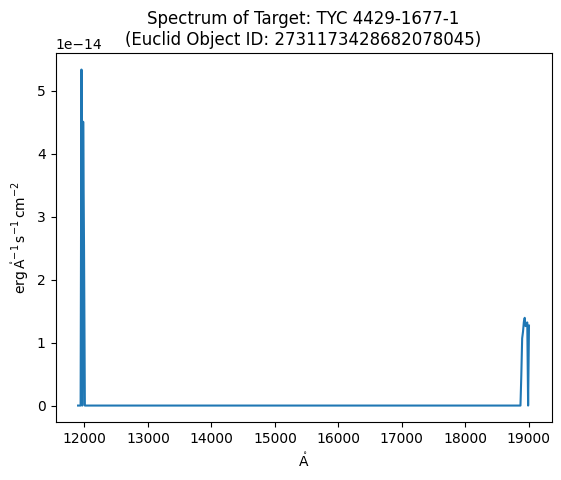

In [32]:
# The signal needs to be multiplied by the scale factor in the header.
plt.plot(spec_tbl['WAVELENGTH'], spec_header['FSCALE'] * spec_tbl['SIGNAL'])
plt.xlabel(spec_tbl['WAVELENGTH'].unit.to_string('latex_inline'))
plt.ylabel(spec_tbl['SIGNAL'].unit.to_string('latex_inline'))

plt.title(f'Spectrum of Target: {target_name}\n(Euclid Object ID: {object_id})');

## About this Notebook

**Author:** Jaladh Singhal (IRSA Developer) in conjunction with Vandana Desai, Brigitta Sipőcz, Tiffany Meshkat, Troy Raen, and the IRSA Data Science Team

**Updated:** 2025-09-23

**Contact:** the [IRSA Helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html) with questions or reporting problems.